# Design a 4 qubit full chip

Creates a complete quantum chip and exports it to GDS.

### Preparations

The next cell enables [module automatic reload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload). Your notebook will be able to pick up code updates made to the qiskit-metal (or other) module code.

In [1]:
%reload_ext autoreload
%autoreload 2

Import key libraries and open the Metal GUI. Also, we configure the notebook to enable overwriting of existing components.

In [2]:
import numpy as np
from collections import OrderedDict

from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

design = designs.DesignPlanar()
gui = MetalGUI(design)

# if you disable the next line, then you will need to delete a component [<component>.delete()] before recreating it
design.overwrite_enabled = True

Import components that will be necessary for the design.

In [3]:
from qiskit_metal.qlibrary.qubits.transmon_pocket_cl import TransmonPocketCL
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled

## Let's design the core of the chip

Setup the design-wide default settings for trace width and trace gap. These can be customized later for individual transmission lines.

In [4]:
design.variables['cpw_width'] = '10 um'
design.variables['cpw_gap'] = '6 um'
design._chips['main']['size']['size_x'] = '9mm'
design._chips['main']['size']['size_y'] = '6.5mm'

We need 4 transmons with 3 connection pads each and a chargeline. Let's explore the options of one transmon

In [5]:
TransmonPocketCL.get_template_options(design)

{'pos_x': '0.0um',
 'pos_y': '0.0um',
 'orientation': '0.0',
 'chip': 'main',
 'layer': '1',
 'connection_pads': {},
 '_default_connection_pads': {'pad_gap': '15um',
  'pad_width': '125um',
  'pad_height': '30um',
  'pad_cpw_shift': '5um',
  'pad_cpw_extent': '25um',
  'cpw_width': 'cpw_width',
  'cpw_gap': 'cpw_gap',
  'cpw_extend': '100um',
  'pocket_extent': '5um',
  'pocket_rise': '65um',
  'loc_W': '+1',
  'loc_H': '+1'},
 'pad_gap': '30um',
 'inductor_width': '20um',
 'pad_width': '455um',
 'pad_height': '90um',
 'pocket_width': '650um',
 'pocket_height': '650um',
 'make_CL': True,
 'cl_gap': '6um',
 'cl_width': '10um',
 'cl_length': '20um',
 'cl_ground_gap': '6um',
 'cl_pocket_edge': '0',
 'cl_off_center': '50um',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False,
 'hfss_inductance': '10nH',
 'hfss_capacitance': 0,
 'hfss_resistance': 0,
 'hfss_mesh_kw_jj': 7e-06,
 'q3d_inductance': '10nH',
 'q3d_capacitance': 0,
 'q3d_resistance': 0,
 'q3d_mesh_kw_jj': 7e-06,
 'gds_cell_name'

We want to change the `pad_width` for these transmons, as well as define the 3 connection pads and chargeline.

To apply the same modifications to all 4 transmons, we define a single option-dictionary to pass to all transmons at the monent of creation.

In [6]:
transmon_options = dict(
    connection_pads=dict(
        a = dict(loc_W=+1, loc_H=-1, pad_width='70um', cpw_extend = '50um'), 
        b = dict(loc_W=-1, loc_H=-1, pad_width='125um', cpw_extend = '50um'),
        c = dict(loc_W=-1, loc_H=+1, pad_width='110um', cpw_extend = '50um')
    ),
    gds_cell_name='FakeJunction_01',
    cl_off_center = '-50um',
    cl_pocket_edge = '180'
)


We can now create the 4 transmons by specifying the desired coordinates and orientations.

In [7]:
offset_tm = 69  #we the transmon slightly out of center-line

q1 = TransmonPocketCL(design, 'Q1', options = dict(
    pos_x='+2420um', pos_y=f'{offset_tm}um', **transmon_options))
q2 = TransmonPocketCL(design, 'Q2', options = dict(
    pos_x='0um', pos_y='-857.6um', orientation = '270', **transmon_options))
q3 = TransmonPocketCL(design, 'Q3', options = dict(
    pos_x='-2420um', pos_y=f'{offset_tm}um', orientation = '180', **transmon_options))
q4 = TransmonPocketCL(design, 'Q4', options = dict(
    pos_x='0um', pos_y='+857.6um', orientation = '90', **transmon_options))

gui.rebuild()
gui.autoscale()

Let's now connect the transmons with transmission lines. We want to have an "exact length" transmission line, so we will use the `RouteMeander`. Let's first observe what the default options are.

In [ ]:
RouteMeander.get_template_options(design)

{'chip': 'main',
 'layer': '1',
 'pin_inputs': {'start_pin': {'component': '', 'pin': ''},
  'end_pin': {'component': '', 'pin': ''}},
 'fillet': '0',
 'lead': {'start_straight': '0mm',
  'end_straight': '0mm',
  'start_jogged_extension': '',
  'end_jogged_extension': ''},
 'total_length': '7mm',
 'trace_width': 'cpw_width',
 'meander': {'spacing': '200um', 'asymmetry': '0um'},
 'snap': 'true',
 'prevent_short_edges': 'true',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False}

09:11PM 06s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  WARNING: QWindowsNativeFileDialogBase::selectNameFilter: Invalid parameter '*.metal.py' not found in 'All Files (*)'.



We want to globally override the default lead (straight initial segment leaving the transmon) and the default fillet (corner rounding radius). Let's collect this information in one dictionary.

In [ ]:
fillet='99.99um'
cpw_options = Dict(
    lead=Dict(
        start_straight='100um',
        end_straight='250um'),
    fillet=fillet
    )

We then want each transmission line to be connected to different pins and to have different lengths and asymmetry w.r.t their centerline. Let's collect this information in other dictionaries. Before doing that, to manage the dictionaries in a simpler way, we redefine the `RouteMeander` signature by wrapping it into a convenient method named `connect`

In [ ]:
def connect(cpw_name: str, pin1_comp_name: str, pin1_comp_pin: str, pin2_comp_name: str, pin2_comp_pin: str,
            length: str, asymmetry='0 um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        pin_inputs=Dict(
            start_pin=Dict(
                component=pin1_comp_name,
                pin=pin1_comp_pin),
            end_pin=Dict(
                component=pin2_comp_name,
                pin=pin2_comp_pin)),
        total_length=length)
    myoptions.update(cpw_options)
    myoptions.meander.asymmetry = asymmetry
    return RouteMeander(design, cpw_name, myoptions)

We can now proceed and define the meanders following the signature: `connect(cpw_name, pin1_comp_name, pin1_comp_pin, pin2_comp_name, pin2_comp_pin, length, asymmetry)`

In [ ]:
asym = 500
cpw1 = connect('cpw1', 'Q1', 'c', 'Q4', 'b', '9000um', f'-{asym-1.25*offset_tm}um')
cpw2 = connect('cpw2', 'Q3', 'b', 'Q4', 'c', '9000um', f'+{asym-1.25*offset_tm}um')
cpw3 = connect('cpw3', 'Q3', 'c', 'Q2', 'b', '9000um', f'-{asym+0.75*offset_tm}um')
cpw4 = connect('cpw4', 'Q1', 'b', 'Q2', 'c', '9000um', f'+{asym+0.75*offset_tm}um')

gui.rebuild()
gui.autoscale()

## Let's now connect the core elements to the launchpads

First we setup the launchpad location and orientation.

In [ ]:
# V1 - Corners
p1_c = LaunchpadWirebond(design, 'P1_C', options = dict(pos_x='3545um', pos_y='2812um', orientation='270', lead_length='0um'))
p2_c = LaunchpadWirebond(design, 'P2_C', options = dict(pos_x='3545um', pos_y='-2812um', orientation='90', lead_length='0um'))
p3_c = LaunchpadWirebond(design, 'P3_C', options = dict(pos_x='-3545um', pos_y='-2812um', orientation='90', lead_length='0um'))
p4_c = LaunchpadWirebond(design, 'P4_C', options = dict(pos_x='-3545um', pos_y='2812um', orientation='270', lead_length='0um'))

# V2
p1_q = LaunchpadWirebondCoupled(design, 'P1_Q', options = dict(pos_x='4020um', pos_y='0', orientation='180', lead_length='30um'))
p2_q = LaunchpadWirebondCoupled(design, 'P2_Q', options = dict(pos_x='-990um', pos_y='-2812um', orientation='90', lead_length='30um'))
p3_q = LaunchpadWirebondCoupled(design, 'P3_Q', options = dict(pos_x='-4020um', pos_y='0', orientation='0', lead_length='30um'))
p4_q = LaunchpadWirebondCoupled(design, 'P4_Q', options = dict(pos_x='990um', pos_y='2812um', orientation='270', lead_length='30um'))

gui.rebuild()
gui.autoscale()

Then we route. First the V2 launchpads - Exchange Coupler Lines to Edges.

In [ ]:
asym = 150
cpw_options = Dict(
    lead=Dict(
        start_straight='430um',
        end_straight='0um'),
    fillet=fillet
    )
ol1 = connect('ol1', 'Q1', 'a', 'P1_Q', 'tie', '8.6 mm', f'+{asym}um')
ol3 = connect('ol3', 'Q3', 'a', 'P3_Q', 'tie', '8.6 mm', f'+{asym}um')

asym = 200
cpw_options = Dict(
    lead=Dict(
        start_straight='535um',
        end_straight='0um'),
    fillet=fillet
    )
ol2 = connect('ol2', 'Q2', 'a', 'P2_Q', 'tie', '8.6 mm', f'+{asym}um')
ol4 = connect('ol4', 'Q4', 'a', 'P4_Q', 'tie', '8.6 mm', f'+{asym}um')

gui.rebuild()
gui.autoscale()

Finally we route the V1 launchpads - Chargelines to Corners.

We create the transmission lines between the corner launchpads and the qubit charge lines.

In [ ]:
from collections import OrderedDict
jogsA_in = OrderedDict()
jogsA_in[0] = ["L", '200um']

options_line_cl1 = {'pin_inputs': 
            {'start_pin': {'component': 'Q1', 'pin': 'Charge_Line'}, 
             'end_pin': {'component': 'P1_C', 'pin': 'tie'}},
            'lead': {'start_straight': '120um', 'end_straight': '225um','start_jogged_extension': jogsA_in},
            'fillet': fillet
            }
cl1 = RouteAnchors(design, 'line_cl1', options_line_cl1)

options_line_cl3 = {'pin_inputs': 
            {'start_pin': {'component': 'Q3', 'pin': 'Charge_Line'}, 
             'end_pin': {'component': 'P3_C', 'pin': 'tie'}},
            'lead': {'start_straight': '120um', 'end_straight': '225um', 'start_jogged_extension': jogsA_in},
            'fillet': fillet
            }
cl3 = RouteAnchors(design, 'line_cl3', options_line_cl3)

gui.rebuild()
gui.autoscale()

In [ ]:
jogsB_in = OrderedDict()
jogsB_in[0] = ["L", '300um']

anchors2c = OrderedDict()
anchors2c[0] = np.array([2, -2.5])

options_line_cl2 = {'pin_inputs': 
            {'start_pin': {'component': 'Q2', 'pin': 'Charge_Line'}, 
             'end_pin': {'component': 'P2_C', 'pin': 'tie'}},
            'lead': {'start_straight': '200um', 'end_straight': '225um',
                     'start_jogged_extension': jogsB_in},
            'anchors': anchors2c,
            'fillet': fillet
            }

cl2 = RouteAnchors(design, 'line_cl2', options_line_cl2)

anchors4c = OrderedDict()
anchors4c[0] = np.array([-2, 2.5])

options_line_cl4 = {'pin_inputs': 
            {'start_pin': {'component': 'Q4', 'pin': 'Charge_Line'}, 
             'end_pin': {'component': 'P4_C', 'pin': 'tie'}},
            'lead': {'start_straight': '200um', 'end_straight': '225um',
                     'start_jogged_extension': jogsB_in},
            'anchors': anchors4c,
            'fillet': fillet
            }

cl4 = RouteAnchors(design, 'line_cl4', options_line_cl4)

gui.rebuild()
gui.autoscale()

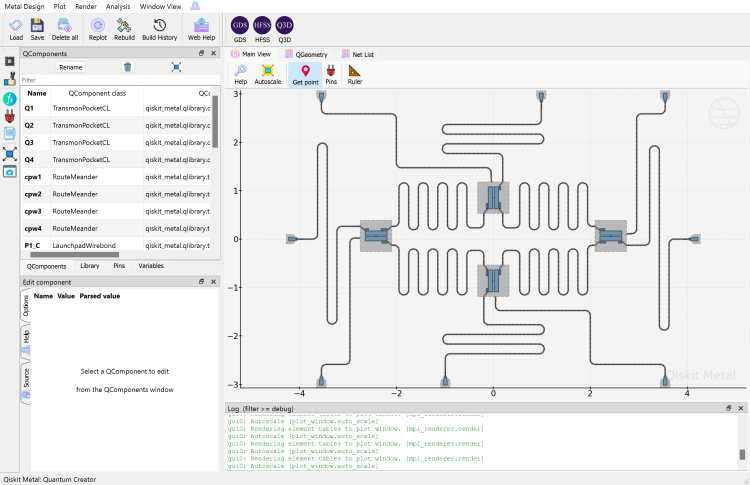

In [ ]:
gui.screenshot()

### Export to GDS

QDesign enables GDS renderer during init. Let's see what the avilable option defaults are.

In [ ]:
a_gds = design.renderers.gds

a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [ ]:
a_gds.options['no_cheese']['buffer'] = '50um'

Correct the path to point to the junction GDS that we intend to include in the output GDS. Then stream out all components in the design.

In [ ]:
a_gds.options['path_filename'] = '../../../tutorials/resources/Fake_Junctions.GDS'
a_gds.export_to_gds("Full_chip_design.gds")

04:53PM 46s WARNING [_import_junctions_to_one_cell]: Not able to find file:"../../../tutorials/resources/Fake_Junctions.GDS".  Not used to replace junction. Checked directory:"c:\Users\jiaop\tutorials\resources".


1

In [ ]:
gui.main_window.close()

KeyboardInterrupt: 

True